In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')
import sys 
sys.path.append("/scratch/izar/kapps/DEX-Cyclic-Arbitrage/")
from config.get import cfg
from tensorflow import keras
from tensorflow.keras import layers
import autoencoders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loaidng data

In [46]:
X_train = np.load(cfg['files']["raw_train_features"])
X_test  = np.load(cfg['files']["raw_test_features"])
print(f"shapes : X_train={X_train.shape},X_test={X_test.shape}")

shapes : X_train=(2698, 3, 600, 2),X_test=(675, 3, 600, 2)


# Loading model

In [47]:

_,autoencoder = autoencoders.fully_connected()
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3, 600, 2)]       0         
                                                                 
 reshape_22 (Reshape)        (None, 3600)              0         
                                                                 
 dense_45 (Dense)            (None, 600)               2160600   
                                                                 
 dense_46 (Dense)            (None, 100)               60100     
                                                                 
 dense_47 (Dense)            (None, 600)               60600     
                                                                 
 dense_48 (Dense)            (None, 3600)              2163600   
                                                                 
 reshape_23 (Reshape)        (None, 3, 600, 2)         0  

In [48]:
hist = autoencoder.fit(X_train, X_train,epochs=100)

Epoch 1/100
85/85 [==============================] - 12s 126ms/step - loss: 0.3738
Epoch 2/100
85/85 [==============================] - 11s 126ms/step - loss: 0.1996
Epoch 3/100
85/85 [==============================] - 11s 127ms/step - loss: 0.1637
Epoch 4/100
85/85 [==============================] - 11s 135ms/step - loss: 0.1468
Epoch 5/100
85/85 [==============================] - 12s 136ms/step - loss: 0.1358
Epoch 6/100
85/85 [==============================] - 11s 135ms/step - loss: 0.1275
Epoch 7/100
85/85 [==============================] - 11s 131ms/step - loss: 0.1202
Epoch 8/100
85/85 [==============================] - 11s 126ms/step - loss: 0.1167
Epoch 9/100
85/85 [==============================] - 11s 126ms/step - loss: 0.1093
Epoch 10/100
85/85 [==============================] - 11s 127ms/step - loss: 0.1038
Epoch 11/100
85/85 [==============================] - 11s 126ms/step - loss: 0.0998
Epoch 12/100
85/85 [==============================] - 11s 125ms/step - loss: 0.1008
E

85/85 [==============================] - 11s 126ms/step - loss: 0.0588
Epoch 99/100
85/85 [==============================] - 11s 127ms/step - loss: 0.0583
Epoch 100/100
85/85 [==============================] - 11s 125ms/step - loss: 0.0592


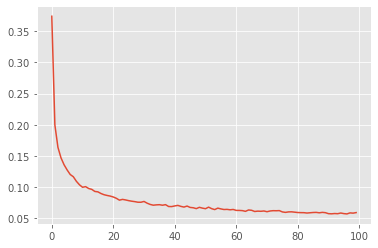

In [49]:
plt.plot(hist.history["loss"])
plt.show()

# testing 

In [50]:
def mean_squared_error(x,y):
    return np.sum((x-y)**2)/x.size

train_pred = autoencoder(X_train).numpy()
test_pred  = autoencoder(X_test).numpy()

print(f"MSE train : {mean_squared_error(train_pred,X_train)} \nMSE test  : {mean_squared_error(test_pred,X_test)}")

MSE train : 0.05457094038337492 
MSE test  : 0.08154374047541027
